<a href="https://colab.research.google.com/github/brayanb1701/Match_Counting/blob/main/Match_Counting_Training_both.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

In [1]:
#### Dependencies ####
####
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
#from manim import *
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
import os
import warnings

## Obtain Git repo

In [2]:
!git clone https://github.com/brayanb1701/Match_Counting.git
os.chdir('Match_Counting')

Cloning into 'Match_Counting'...
remote: Enumerating objects: 2410, done.
remote: Counting objects: 100% (1099/1099), done.
remote: Compressing objects: 100% (1095/1095), done.
remote: Total 2410 (delta 5), reused 1097 (delta 3), pack-reused 1311
Receiving objects: 100% (2410/2410), 309.73 MiB | 36.18 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (2501/2501), done.


## Loading audios with librosa

In [3]:
def load_audios(BASE_FOLDER,sr):
  files = os.listdir(BASE_FOLDER)
  raw_audio = []
  labels = []
  for f in files:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      audio, _ = librosa.load(os.path.join(BASE_FOLDER, f),sr=sr, offset=0.2, duration=5)
      #audio, _ = librosa.load(os.path.join(BASE_FOLDER, f),sr=sr)
    raw_audio.append(audio)
    name = f.split(".")[0]
    labels.append(int(name.split("-")[1]))
  return raw_audio,labels

In [5]:
BASE_FOLDER1="temporal/"
BASE_FOLDER2="caja_refuegos/"
sr = 44100
raw_audio,labels = load_audios(BASE_FOLDER1,sr)
raw_audio2,labels2 = load_audios(BASE_FOLDER2,sr)
raw_audio = raw_audio + raw_audio2
labels = labels + labels2

## Initial visualization of audios

In [6]:
def plot_magnitude_spectrum(signal, sr, title, f_ratio=1):
    X = np.fft.fft(signal)
    X_mag = np.absolute(X)
    
    plt.figure(figsize=(18, 5))
    
    f = np.linspace(0, sr, len(X_mag))
    f_bins = int(len(X_mag)*f_ratio)  
    print(len(X_mag))
    print(f_bins)
    plt.plot(f[:f_bins], X_mag[:f_bins])
    plt.xlabel('Frequency (Hz)')
    plt.title(title)

In [7]:
BASE_FOLDER = BASE_FOLDER1

In [8]:
ipd.Audio(os.path.join(BASE_FOLDER, os.listdir(BASE_FOLDER)[0])) 

220500
73500


Text(0.5, 1.0, 'Signal')

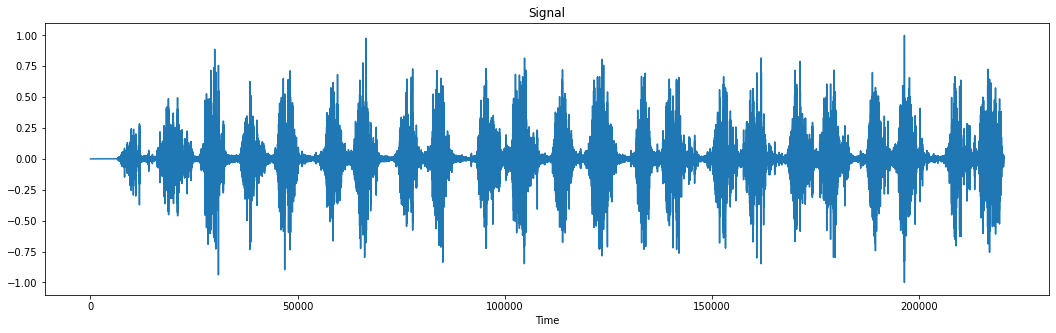

<Figure size 1296x360 with 0 Axes>

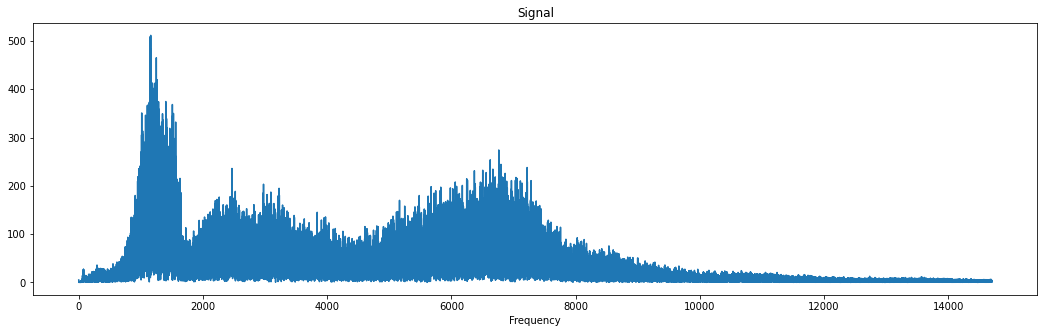

In [9]:
plt.figure(num=1,figsize=(18, 5))
plt.plot(raw_audio[0])
plt.xlabel('Time')
plt.title("Signal")

plt.figure(num=2,figsize=(18, 5))
plot_magnitude_spectrum(raw_audio[0], sr, "Audio ejemplo", 1/3)
plt.xlabel('Frequency')
plt.title("Signal")

## Obtain FFT and MFCC for an array of audios

In [10]:
def obtain_fft_mfcc(raw_audio):
  mfccs_processed = []
  ffts_mag = []
  len_fft = 85000
  for i in raw_audio:
    X = np.fft.fft(i)
    ffts_mag.append(np.absolute(X[:len_fft]))
    mfccs = librosa.feature.mfcc(y=i, sr=sr, n_mfcc=40)
    mfccs_processed.append(np.mean(mfccs.T,axis=0))
  return ffts_mag,mfccs_processed

In [11]:
ffts_mag,mfccs_processed = obtain_fft_mfcc(raw_audio)

## Create a Dataframe with all the data

In [12]:
df = pd.DataFrame(list(zip(raw_audio, ffts_mag, mfccs_processed, labels)),
               columns =['Raw_Audio', 'FFT', "MFCC", "Number_Matches"])

In [13]:
df.head()

,Raw_Audio,FFT,MFCC,Number_Matches
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.21649169921875, 1.1328755079211197, 0.53656...","[-213.58472, 71.93911, -118.93639, 27.797983, ...",120
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.129547119140625, 0.9995431682851608, 0.6900...","[-266.5775, 106.36762, -99.5862, 10.5401125, -...",19
2,"[-0.00035095215, -0.00035095215, -0.0003356933...","[8.7574462890625, 1.9005340253806462, 0.192542...","[-316.40668, 90.776726, -99.54086, 14.374751, ...",120
3,"[-0.00050354004, -0.00050354004, -0.0005035400...","[8.84344482421875, 0.7967449673309753, 0.82538...","[-282.30756, 106.19009, -101.9004, 13.506569, ...",7
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[61.124786376953125, 3.055092729542953, 3.7140...","[-198.66452, 64.30795, -105.68582, 51.461628, ...",18


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Raw_Audio       2050 non-null   object
 1   FFT             2050 non-null   object
 2   MFCC            2050 non-null   object
 3   Number_Matches  2050 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 64.2+ KB


## Define the inputs and labels

In [15]:
X = np.array(df.MFCC.tolist())
y = np.array(df.Number_Matches.tolist())

In [16]:
np.shape(X)

(2050, 40)

In [17]:
seed = np.random.seed(20) #Make reproducible

## Split the data for training and testing

In [18]:
#@title
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

In [19]:
#@title
y_test

array([  8,  35,   3,   4, 120, 100, 120,   8,  80,  60,   5, 100,  18,
        13,  19,  14,  65,  13,  45,   6,  70,  26,   2,  30,  70,  50,
       130,  18,  17,  30,  26,  15,   7,   6,  35,  65,  10,   6,  14,
        30,  50,  14,  40,   9,  55,  22,  14, 150,  26,  17,  14,  90,
        19,   5,   4,  26,  55,  16,  80, 120,  70, 120,   7, 110, 150,
       130, 140,   6,  45,  70,   9,  10,  65,  15,  50,  60,  24,   2,
        16,  11,   7,  40, 140,  15,  90,   9,   4,  24, 110,  28,  20,
        80,  18,  26,  19,   8,   1,  30,  22,  14,   7,   1,  17,  24,
        19,  40,  80,  11,  28,  11,  18,  11,  16, 130,  18,  19,  16,
        26,   5,   2, 150, 110,  15,  90,  80,  65,   3,   3,  20,  16,
       100,  70,   1,  90,  40,  11,  22, 130,  26,   5,  55,   7,  28,
        16, 140,  35,  12,  22,  24,  90,  12, 100,  60,  50,   5,  24,
       140,  70,  20,   7,  16,   8,   1,  45,   4,  60,  19, 130,  28,
        90,  10,  17,   3,   6, 100,  10,  26,  45,  10,  10,  6

## DNN model 

In [21]:
def build_model_MFCC():
  model = tf.keras.Sequential([
                             tf.keras.layers.Dense(40, activation='relu', input_shape=[x_train.shape[1]]),
                             tf.keras.layers.Dense(20, activation='relu'),
                             tf.keras.layers.Dropout((0.2)),
                             tf.keras.layers.Dense(10, activation='relu'),
                             tf.keras.layers.Dense(1)])


  # Choose the preference optimizer.
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  
  #Select the loss function (MSE)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model_MFCC = build_model_MFCC();
model_MFCC.summary()  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dense_5 (Dense)             (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,681
Trainable params: 2,681
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [22]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_MFCC3.hdf5', verbose=1, save_best_only=True)
#earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [23]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
num_epochs = 200
num_batch_size = 32
history_model_MFCC = model_MFCC.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, callbacks=[checkpointer], validation_data=(x_test, y_test), verbose=1)

Epoch 1/200
43/52 [=======================>......] - ETA: 0s - loss: 2237.3440 - mae: 36.5269 - mse: 2237.3440 
Epoch 1: val_loss improved from inf to 1670.62183, saving model to Models/model_MFCC3.hdf5
52/52 [==============================] - 1s 5ms/step - loss: 2167.7009 - mae: 36.1192 - mse: 2167.7009 - val_loss: 1670.6218 - val_mae: 32.4403 - val_mse: 1670.6218
Epoch 2/200
38/52 [====================>.........] - ETA: 0s - loss: 1811.7015 - mae: 33.0474 - mse: 1811.7015
Epoch 2: val_loss improved from 1670.62183 to 1468.03601, saving model to Models/model_MFCC3.hdf5
52/52 [==============================] - 0s 2ms/step - loss: 1682.9701 - mae: 31.7383 - mse: 1682.9701 - val_loss: 1468.0360 - val_mae: 29.1930 - val_mse: 1468.0360
Epoch 3/200
36/52 [===================>..........] - ETA: 0s - loss: 1548.3057 - mae: 30.0140 - mse: 1548.3057
Epoch 3: val_loss improved from 1468.03601 to 1211.18201, saving model to Models/model_MFCC3.hdf5
52/52 [==============================] - 0s 3ms/s

### Results of accuracy

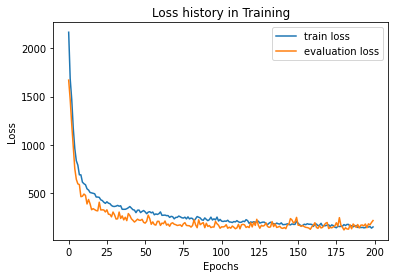

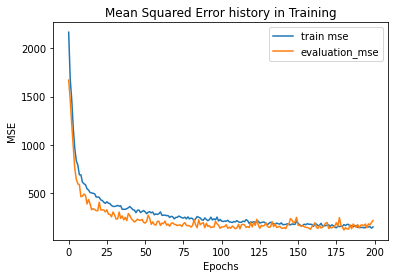

In [61]:
plt.plot(history_model_MFCC.history['loss'], label='train loss');
plt.plot(history_model_MFCC.history['val_loss'], label='evaluation loss');
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss history in Training")
plt.legend()
plt.show();

plt.plot(history_model_MFCC.history['mse'], label='train mse');
plt.plot(history_model_MFCC.history['val_mse'], label='evaluation_mse');
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Mean Squared Error history in Training")
plt.legend()
plt.show()

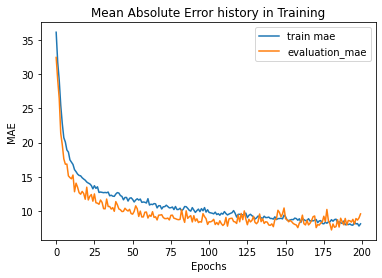

In [62]:
plt.plot(history_model_MFCC.history['mae'], label='train mae');
plt.plot(history_model_MFCC.history['val_mae'], label='evaluation_mae');
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Mean Absolute Error history in Training")
plt.legend()
plt.show()

In [26]:
loss, mae, mse = model_MFCC.evaluate(x_test, y_test)
loss, mae, mse

13/13 [==============================] - 0s 1ms/step - loss: 212.6069 - mae: 9.5984 - mse: 212.6069


(212.60687255859375, 9.59838581085205, 212.60687255859375)

In [ ]:
#@title
result = model_MFCC.predict(np.reshape(x_test[0],[1,40]))
int(result[0])

1/1 [==============================] - 0s 72ms/step


17

In [ ]:
#@title
result = model_MFCC.predict(x_test[0:30])
result

1/1 [==============================] - 0s 17ms/step


array([[17.296782 ],
       [17.699045 ],
       [23.297766 ],
       [45.71334  ],
       [92.81062  ],
       [38.510242 ],
       [11.15623  ],
       [75.70886  ],
       [62.713684 ],
       [93.18596  ],
       [38.08197  ],
       [75.981575 ],
       [73.79611  ],
       [27.631521 ],
       [37.81626  ],
       [39.52239  ],
       [79.47704  ],
       [11.264177 ],
       [ 5.227131 ],
       [13.008332 ],
       [52.506424 ],
       [91.81598  ],
       [ 4.5381703],
       [71.110405 ],
       [40.320705 ],
       [13.480796 ],
       [17.293156 ],
       [ 9.061843 ],
       [10.962004 ],
       [ 3.89249  ]], dtype=float32)

In [ ]:
#@title
y_test[:30]

array([ 15,  24,  20,  28,  90,  28,   7, 120,  55, 150, 110, 110,  90,
        35,  45,  45,  90,  12,   3,  10,  50, 120,   3,  80,  24,  16,
        14,   7,  10,   6])

## Load DNN Model

In [27]:
model_loaded = tf.keras.models.load_model('Models/model_MFCC3.hdf5')

### Results of precision

In [28]:
loss, mae, mse = model_loaded.evaluate(x_test, y_test)
loss, mae, mse

13/13 [==============================] - 0s 1ms/step - loss: 115.3056 - mae: 7.2615 - mse: 115.3056


(115.30561828613281, 7.261507987976074, 115.30561828613281)

In [29]:
#@title
result = model_loaded.predict(np.reshape(x_test[0],[1,40]))
int(result[0])

1/1 [==============================] - 0s 78ms/step


8

In [30]:
#@title
result = model_loaded.predict(x_test[0:30])
print((np.rint(result)).astype(int))

1/1 [==============================] - 0s 18ms/step
[[  9]
 [ 24]
 [  4]
 [ 15]
 [139]
 [ 99]
 [114]
 [  9]
 [ 89]
 [ 31]
 [  8]
 [107]
 [ 15]
 [ 17]
 [ 14]
 [ 16]
 [ 64]
 [ 12]
 [ 40]
 [ 12]
 [ 57]
 [ 20]
 [  6]
 [ 35]
 [ 63]
 [ 43]
 [130]
 [ 26]
 [ 18]
 [ 31]]


In [31]:
#@title
y_test[:30]

array([  8,  35,   3,   4, 120, 100, 120,   8,  80,  60,   5, 100,  18,
        13,  19,  14,  65,  13,  45,   6,  70,  26,   2,  30,  70,  50,
       130,  18,  17,  30])

In [33]:
def moving_window(y_test, y_pred, size):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  mov_test = []
  mov_pred = []
  for i in range(len(y_test) - (size-1)):
    mov_test.append(y_test[i:i+size])
    mov_pred.append(y_pred[i:i+size])
  return mov_test,mov_pred

In [34]:
def local_MSE(yg_test,yg_pred):
  l_MSE = []
  for idx, m_t in enumerate(yg_test):
    l_MSE.append(mean_squared_error(m_t,yg_pred[idx]))
  return np.array(l_MSE)

def local_MAE(yg_test,yg_pred):
  l_MSE = []
  for idx, m_t in enumerate(yg_test):
    l_MSE.append(mean_absolute_error(m_t,yg_pred[idx]))
  return np.array(l_MSE)


In [35]:
def own_grouping(y_test, y_pred, o_sz_group, sz_split, grouping):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  yg_test = []
  yg_pred = []
  size_group = int(o_sz_group*sz_split)
  idx_prev = 0
  for i in grouping:
    idx_n = i*size_group
    yg_test.append(y_test[idx_prev:idx_n])
    yg_pred.append(y_pred[idx_prev:idx_n])
    idx_prev = idx_n
  return yg_test,yg_pred

In [36]:
def moving_window_average(array,size):
  #idx_sort = np.argsort(array)
  #array = array[idx_sort]
  mov_avg_array = []
  for i in range(len(array) - (size-1)):
    #print(array[i:i+size])
    mov_avg_array.append(np.mean(array[i:i+size]))
  
  return mov_avg_array

In [37]:
result = model_loaded.predict(x_test)

13/13 [==============================] - 0s 2ms/step


In [38]:
grouping = [20, 25, 33, 41]
ygo_test,ygo_pred = own_grouping(y_test, result, 25, 0.2, grouping)

Text(0.5, 1.0, 'Grouped RMSE by increment')

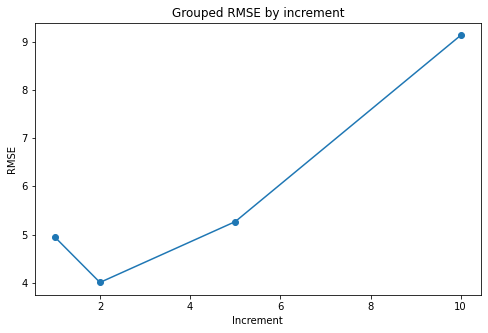

In [39]:
grouped_MSE = local_MSE(ygo_test,ygo_pred)
grouped_RMSE = np.sqrt(grouped_MSE)
increments = [1, 2, 5, 10]
plt.figure(num=1,figsize=(8, 5))
plt.plot(increments,grouped_RMSE, '-o')
plt.xlabel("Increment")
plt.ylabel("RMSE")
plt.title("Grouped RMSE by increment")

Text(0.5, 1.0, 'Grouped MAE by increment')

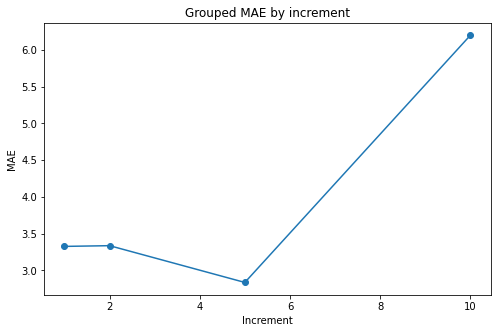

In [40]:
grouped_MAE = local_MAE(ygo_test,ygo_pred)
plt.figure(num=1,figsize=(8, 5))
increments = [1, 2, 5, 10]
plt.plot(increments,grouped_MAE, '-o')
plt.xlabel("Increment")
plt.ylabel("MAE")
plt.title("Grouped MAE by increment")

In [43]:
def own_grouping2(y_test, y_pred, o_sz_group, sz_split):
  idx_sort = np.argsort(y_test)
  y_test = y_test[idx_sort]
  y_pred = y_pred[idx_sort]
  yg_test = []
  yg_pred = []
  size_group = int(o_sz_group*sz_split)
  idx_prev = 0
  for i in range(size_group,len(y_test)+1,size_group):
    idx_n = i
    yg_test.append(y_test[idx_prev:idx_n])
    yg_pred.append(y_pred[idx_prev:idx_n])
    idx_prev = idx_n
  return yg_test,yg_pred

In [47]:
ygo_test2,ygo_pred2 = own_grouping2(y_test, result, 50, 0.2)

In [52]:
mean_ygo_test2

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  22.,  24.,
        26.,  28.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        80.,  90., 100., 110., 120., 130., 140., 150.])

In [53]:
mean_ygo_pred2

array([[  5.6004877],
       [  4.5312624],
       [  8.178307 ],
       [  5.6828723],
       [  7.153135 ],
       [  9.1319895],
       [  8.417605 ],
       [ 10.402005 ],
       [ 10.229288 ],
       [ 11.149071 ],
       [ 13.281367 ],
       [ 13.706828 ],
       [ 14.5117035],
       [ 14.487467 ],
       [ 17.235079 ],
       [ 16.545488 ],
       [ 17.835392 ],
       [ 16.070835 ],
       [ 15.088121 ],
       [ 25.441982 ],
       [ 19.335194 ],
       [ 22.460218 ],
       [ 20.390306 ],
       [ 28.050058 ],
       [ 27.447002 ],
       [ 25.853067 ],
       [ 32.935028 ],
       [ 43.75417  ],
       [ 44.770855 ],
       [ 55.361217 ],
       [ 56.08423  ],
       [ 70.76647  ],
       [ 61.061047 ],
       [ 87.06523  ],
       [ 89.24727  ],
       [105.08588  ],
       [100.141655 ],
       [111.049484 ],
       [120.949425 ],
       [123.339066 ],
       [133.24838  ]], dtype=float32)

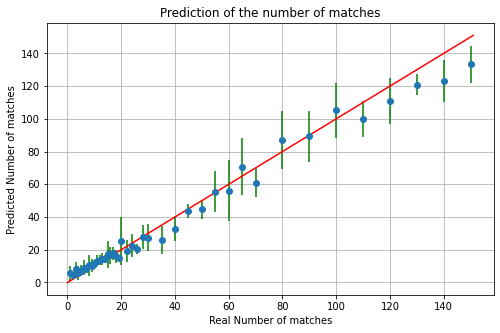

In [51]:
mean_ygo_test2 = np.mean(ygo_test2,axis=1)
mean_ygo_pred2 = np.mean(ygo_pred2,axis=1)
std_ygo_pred2 = np.std(ygo_pred2,axis=1)
x_line = np.linspace(0,151,1000)
y_line = np.linspace(0,151,1000)
plt.figure(num=1,figsize=(8, 5))
plt.errorbar(mean_ygo_test2,mean_ygo_pred2, yerr=np.reshape(std_ygo_pred2, (41)), fmt='o',ecolor='g', capthick=1)
plt.plot(x_line,y_line, c='red')
plt.xlabel("Real Number of matches")
plt.ylabel("Predicted Number of matches")
plt.title("Prediction of the number of matches")
plt.grid()

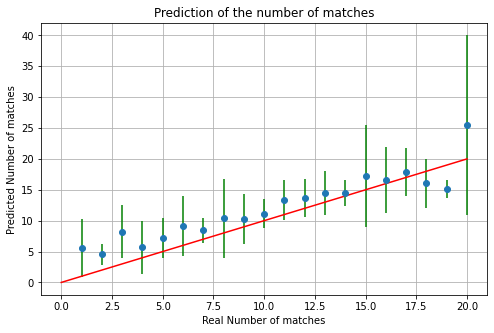

In [55]:
mean_ygo_test2 = np.mean(ygo_test2,axis=1)
mean_ygo_pred2 = np.mean(ygo_pred2,axis=1)
std_ygo_pred2 = np.std(ygo_pred2,axis=1)
x_line = np.linspace(0,20,1000)
y_line = np.linspace(0,20,1000)
plt.figure(num=1,figsize=(8, 5))
plt.errorbar(mean_ygo_test2[:20],mean_ygo_pred2[:20], yerr=np.reshape(std_ygo_pred2[:20], (20)), fmt='o',ecolor='g', capthick=1)
plt.plot(x_line,y_line, c='red')
plt.xlabel("Real Number of matches")
plt.ylabel("Predicted Number of matches")
plt.title("Prediction of the number of matches")
plt.grid()

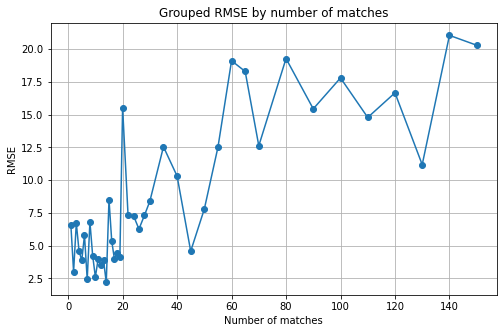

In [60]:
grouped_MSE2 = local_MSE(ygo_test2,ygo_pred2)
grouped_RMSE2 = np.sqrt(grouped_MSE2)
x=np.concatenate([np.arange(1,21,1),np.arange(22,31,2),np.arange(35,71,5),np.arange(80,151,10)])
plt.figure(num=1,figsize=(8, 5))
plt.plot(x,grouped_RMSE2, '-o')
plt.xlabel("Number of matches")
plt.ylabel("RMSE")
plt.title("Grouped RMSE by number of matches")
plt.grid()

In [57]:
grouped_RMSE2

array([ 6.58842403,  3.01422964,  6.72776365,  4.59139947,  3.87778034,
        5.79555157,  2.42634251,  6.81861603,  4.2446349 ,  2.61362572,
        3.96089478,  3.5143904 ,  3.87637925,  2.19327521,  8.52279324,
        5.37363816,  3.95686722,  4.4102426 ,  4.1624051 , 15.53780324,
        7.31078395,  7.28688928,  6.2725576 ,  7.30729595,  8.39731409,
       12.55466792, 10.31823405,  4.58171403,  7.79730975, 12.51765098,
       19.12683248, 18.30857365, 12.63158108, 19.2926661 , 15.45133731,
       17.81257643, 14.79356424, 16.67573968, 11.19117662, 21.06436625,
       20.31029459])

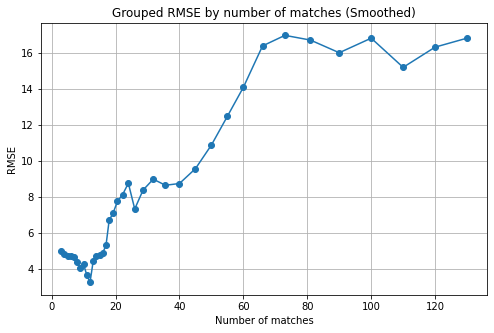

In [59]:
size=5
moving_RMSE2 = moving_window_average(grouped_RMSE2,size)
x=moving_window_average(np.concatenate([np.arange(1,21,1),np.arange(22,31,2),np.arange(35,71,5),np.arange(80,151,10)]),size)
plt.figure(num=1,figsize=(8, 5))
plt.plot(x,moving_RMSE2, '-o')
plt.xlabel("Number of matches")
plt.ylabel("RMSE")
plt.title("Grouped RMSE by number of matches (Smoothed)")
plt.grid()

In [ ]:
grouped_MSE2 = local_MSE(ygo_test2,ygo_pred2)


In [ ]:
x

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  22,  24,  26,  28,  30,  35,
        40,  45,  50,  55,  60,  65,  70,  80,  90, 100, 110, 120, 130,
       140, 150])

In [ ]:
grouped_RMSE2

array([ 3.76972834,  2.03090594,  1.5809644 ,  1.43411616,  1.86191578,
        5.50467838,  2.8864278 ,  2.74408643,  2.90260312,  3.53562689,
        2.09061265,  3.45638926,  2.72506524,  3.40873805,  6.41290475,
        5.67283491,  3.93855207,  5.0401781 ,  4.23991994,  4.69161252,
        6.22223296,  7.65238264,  8.14863949,  5.62142002,  6.00315592,
       11.6786614 , 14.17720176, 20.38155313, 14.57188853, 12.55333572,
        9.21368513, 25.05758074, 14.52778444, 11.34609088, 14.09670111,
       22.75037728, 26.32386097, 18.87766166, 10.26956093, 26.53863823,
       20.35788587])

Text(0.5, 1.0, 'Grouped MAE by number of matches')

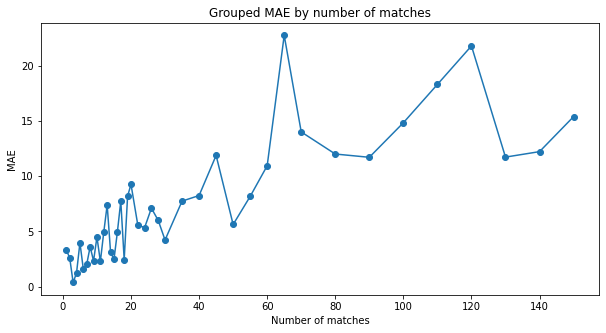

In [ ]:
grouped_MAE2 = local_MAE(ygo_test2,ygo_pred2)
x=np.concatenate([np.arange(1,21,1),np.arange(22,31,2),np.arange(35,71,5),np.arange(80,151,10)])
plt.figure(num=1,figsize=(10, 5))
plt.plot(x,grouped_MAE2, '-o')
plt.xlabel("Number of matches")
plt.ylabel("MAE")
plt.title("Grouped MAE by number of matches")

In [ ]:
mov_test,mov_pred  = moving_window(y_test, result, 20)

Text(0.5, 1.0, 'Moving Error RMSE')

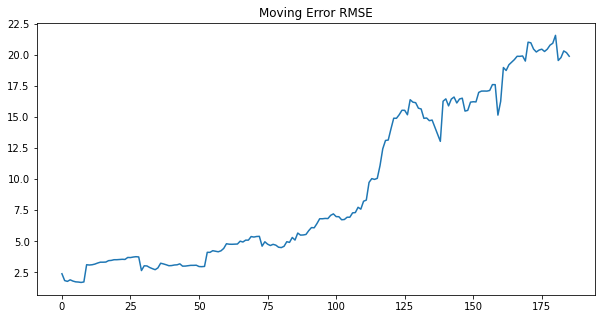

In [ ]:
moving_MSE = local_MSE(mov_test,mov_pred)
moving_RMSE = np.sqrt(moving_MSE)
plt.figure(num=1,figsize=(10, 5))
plt.plot(moving_RMSE)
plt.title("Moving Error RMSE")

Text(0.5, 1.0, 'Moving Error MAE')

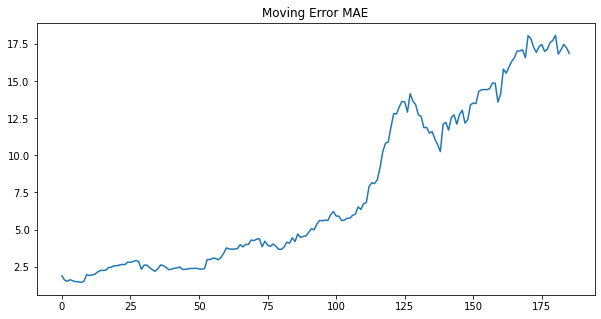

In [ ]:
moving_MAE = local_MAE(mov_test,mov_pred)
plt.figure(num=1,figsize=(10, 5))
plt.plot(moving_MAE)
plt.title("Moving Error MAE")

In [ ]:
idx_sort1 = np.argsort(y_test)
y_test_sorted = y_test[idx_sort1]
y_pred_sorted = result[idx_sort1]


plt.figure(num=1,figsize=(10, 5))
plt.plot(y_test_sorted)
plt.plot(mov_test)
plt.title("Real")

plt.figure(num=2,figsize=(10, 5))
plt.plot(y_pred_sorted)
plt.plot(mov_pred)
plt.title("Predicted")

## Other things (not organized)

In [ ]:
!unzip mov_largo_vertical.zip

In [ ]:

#raw_audio = []
#ffts_mag = []
x_eval = []
y_eval = []

BASE_PATH_LARGE='mov_largo'
files = os.listdir(BASE_PATH_LARGE)
for f in files:
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    audio, _ = librosa.load(os.path.join(BASE_PATH_LARGE, f),sr=sr)
  #raw_audio.append(audio)
  name = f.split(".")[0]
  y_eval.append(int(name.split("-")[1]))
  #X = np.fft.fft(audio)
  #ffts_mag.append(np.absolute(X[:len_fft]))
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
  x_eval.append(np.mean(mfccs.T,axis=0))
  

In [ ]:
x_eval = np.array(x_eval)
y_eval = np.array (y_eval)
loss, mae, mse = model_MFCC.evaluate(x_eval, y_eval)
loss, mae, mse

2/2 [==============================] - 0s 8ms/step - loss: 2532.2512 - mae: 41.9118 - mse: 2532.2512


(2532.251220703125, 41.91179656982422, 2532.251220703125)

In [ ]:
!unzip caja_peq_refuegos.zip

In [ ]:
#!rm -r 'caja_peq/.ipynb_checkpoints'

In [ ]:

#raw_audio = []
#ffts_mag = []
x_eval = []
y_eval = []


BASE_PATH_PEQ='caja_peq'
files = os.listdir(BASE_PATH_PEQ)
for f in files:
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    audio, _ = librosa.load(os.path.join(BASE_PATH_PEQ, f),sr=sr)
  #raw_audio.append(audio)
  name = f.split(".")[0]
  y_eval.append(int(name.split("-")[1]))
  #X = np.fft.fft(audio)
  #ffts_mag.append(np.absolute(X[:len_fft]))
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
  x_eval.append(np.mean(mfccs.T,axis=0))



In [ ]:
x_eval = np.array(x_eval)
y_eval = np.array (y_eval)
loss, mae, mse = model_MFCC.evaluate(x_eval, y_eval)
loss, mae, mse

2/2 [==============================] - 0s 6ms/step - loss: 6513.0420 - mae: 74.6580 - mse: 6513.0420


(6513.0419921875, 74.65796661376953, 6513.0419921875)

In [ ]:
len(x_eval)

35

In [ ]:
X1 = np.array(df.FFT.tolist())
y1 = np.array(df.Number_Matches.tolist())

In [ ]:
np.shape(X1)

(1025, 85000)

In [ ]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

In [ ]:
def build_model_fft():
  model = tf.keras.Sequential([
                             tf.keras.layers.Dense(16, activation='relu', input_shape=[x1_train.shape[1]]),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dropout((0.2)),
                             tf.keras.layers.Dense(16, activation='relu'),
                             tf.keras.layers.Dense(1)])


  # Choose the preference optimizer.
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  
  #Select the loss function (MSE)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model_fft = build_model_fft();
model_fft.summary()  

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 16)                1360016   
                                                                 
 dense_53 (Dense)            (None, 32)                544       
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_54 (Dense)            (None, 16)                528       
                                                                 
 dense_55 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,361,105
Trainable params: 1,361,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
num_epochs = 100
num_batch_size = 32
history1 = model_fft.fit(x1_train, y1_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x1_test, y1_test), verbose=1)

Epoch 1/100
26/26 [==============================] - 2s 32ms/step - loss: 202384.8906 - mae: 257.8144 - mse: 202384.8906 - val_loss: 3349.3711 - val_mae: 39.7584 - val_mse: 3349.3711
Epoch 2/100
26/26 [==============================] - 1s 23ms/step - loss: 3406.7529 - mae: 41.2118 - mse: 3406.7529 - val_loss: 3341.9585 - val_mae: 39.6651 - val_mse: 3341.9585
Epoch 3/100
26/26 [==============================] - 1s 24ms/step - loss: 3397.2759 - mae: 41.0979 - mse: 3397.2759 - val_loss: 3331.2390 - val_mae: 39.5297 - val_mse: 3331.2390
Epoch 4/100
26/26 [==============================] - 1s 24ms/step - loss: 3384.7659 - mae: 40.9441 - mse: 3384.7659 - val_loss: 3318.0835 - val_mae: 39.3630 - val_mse: 3318.0835
Epoch 5/100
26/26 [==============================] - 1s 24ms/step - loss: 3370.5896 - mae: 40.7653 - mse: 3370.5896 - val_loss: 3302.5647 - val_mae: 39.1654 - val_mse: 3302.5647
Epoch 6/100
26/26 [==============================] - 1s 24ms/step - loss: 3351.6150 - mae: 40.5406 - mse:

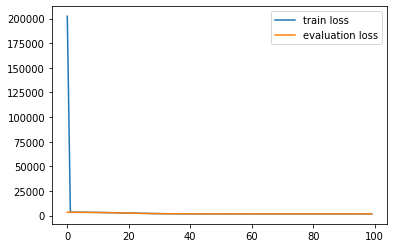

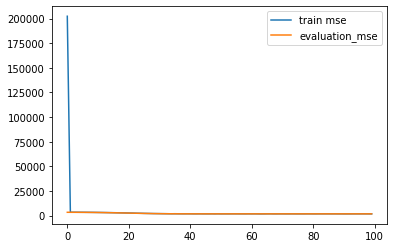

In [ ]:
plt.plot(history1.history['loss'], label='train loss');
plt.plot(history1.history['val_loss'], label='evaluation loss');
plt.legend()
plt.show();

plt.plot(history1.history['mse'], label='train mse');
plt.plot(history1.history['val_mse'], label='evaluation_mse');
plt.legend()
plt.show()

In [ ]:
loss1, mae1, mse1 = model_fft.evaluate(x1_test, y1_test)
loss1, mae1, mse1

7/7 [==============================] - 0s 7ms/step - loss: 1768.7635 - mae: 33.5938 - mse: 1768.7635


(1768.7635498046875, 33.593807220458984, 1768.7635498046875)

In [ ]:
result1 = model_fft.predict(np.reshape(x1_test[0],[1,85000]))
int(result[0])

1/1 [==============================] - 0s 294ms/step


39

In [ ]:
result1 = model_fft.predict(x1_test[0:30])
result1

1/1 [==============================] - 0s 32ms/step


array([[39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881],
       [39.42881]], dtype=float32)

In [ ]:
y1_test[:30]

array([ 17, 100,  17,  60,  10, 150,  11, 130,   2,   2,   6, 150,  22,
        20,  45,   6,  15,  14,  15,  16,  70,  28,  14,  17,  28,  90,
         7,  18, 100,  55])

## Others

In [ ]:
!sudo apt update
!sudo apt install libcairo2-dev ffmpeg \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev
!pip install manim
!pip install IPython --upgrade

In [ ]:
!pip install manim_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 1.8 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/helblazer811/ManimML.git


Cloning into 'ManimML'...
remote: Enumerating objects: 924, done.
remote: Counting objects: 100% (923/923), done.
remote: Compressing objects: 100% (397/397), done.
remote: Total 924 (delta 530), reused 872 (delta 483), pack-reused 1
Receiving objects: 100% (924/924), 222.76 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (530/530), done.
Checking out files: 100% (187/187), done.


In [ ]:
from manim import *
from manim_ml.neural_network.layers import FeedForwardLayer
from manim_ml.neural_network.neural_network import NeuralNetwork
from manim_ml.neural_network.neural_network import EmbeddingLayer

In [ ]:
#@title Texto de título predeterminado
%%manim -qm -v WARNING VariationalAutoencoderScene

class VariationalAutoencoderScene(Scene):

    def construct(self):
        embedding_layer = EmbeddingLayer(dist_theme="ellipse").scale(2)
        
        #image = Image.open('images/image.jpeg')
        #numpy_image = np.asarray(image)
        # Make nn
        neural_network = NeuralNetwork([
            #ImageLayer(numpy_image, height=1.4),
            FeedForwardLayer(5),
            FeedForwardLayer(3),
            embedding_layer,
            FeedForwardLayer(3),
            FeedForwardLayer(5),
            #ImageLayer(numpy_image, height=1.4),
        ], layer_spacing=0.6)

        neural_network.scale(1.5)

        self.play(Create(neural_network))
        self.play(neural_network.make_forward_pass_animation(run_time=15))

class NeuralNetworkScene(Scene):
    """Test Scene for the Neural Network"""

    def construct(self):
        # Make the Layer object
        layers = [FeedForwardLayer(3), FeedForwardLayer(5), FeedForwardLayer(3)]
        nn = NeuralNetwork(layers)
        nn.scale(2)
        nn.move_to(ORIGIN)
        # Make Animation
        self.add(nn)
        # self.play(Create(nn))
        forward_propagation_animation = nn.make_forward_pass_animation(
            run_time=5, passing_flash=True
        )

        self.play(forward_propagation_animation)
